### <center>AI Project 2

<center>By Darshan Arvind Solanki (das968) and Vishnu Thakral (vvt223)


In [0]:
#using tensrflow version 1.x
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
#importing all relevant libraries that are to be used
import numpy as np
import subprocess
import pickle
import torch
import os
import random
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from torchvision import transforms
from PIL import Image
import argparse
import os.path
import random
import torch

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D



Using TensorFlow backend.


In [0]:
#loading regular mnist dataset (non rotated images of numbers)
mnist_path = "mnist.npz"

# From URL: https://github.com/fchollet/keras/blob/master/keras/datasets/mnist.py

if not os.path.exists(mnist_path):
    subprocess.call("wget https://s3.amazonaws.com/img-datasets/mnist.npz", shell=True)

f = np.load('mnist.npz')
#Load the dataset in the file to test and test respectively
x_tr = torch.from_numpy(f['x_train'])
y_tr = torch.from_numpy(f['y_train']).long()
x_te = torch.from_numpy(f['x_test'])
y_te = torch.from_numpy(f['y_test']).long()
f.close()

torch.save((x_tr, y_tr), 'mnist_train.pt')
torch.save((x_te, y_te), 'mnist_test.pt')




This function is used to rotate the images as per the parameters used by the  FaceBook Researchers while creating the dataset.

-n_tasks is the number of layers where each layer represents the degree of rotation performed on the images.These are stored as tensor objects with the convention (degree, tensor image vector, tensor labels)
-min_rot - set to 0 degree
-max_rot - set to 180 degree

Individual rotation - min_rot and max_rot calculated then final degree of rotation is done random_multipier * (max-min) + min 

The rotation range at each level is incremented in steps of 9 i.e the layer 1 has rotation range between 0 and 9, layer 2 has been 9 and 18 and so on for each consecutive layer till we reach the 20th layer that can have a rotation value upto 180 degrees.

The amount of rotation that is added at each layer is calculated with the help of randomness.To calculate the rotation we multiply the range of rotation at each layer i.e (max_rotation - min_rotation) with a random value between 0 and 1 and add the min_rotation to generate the overall rotation at the particular layer.

After all computation are performed the rotated train and test dataset are stored as torch object.


**Note**<br>
Size of both files is about 8Gb.<br>
Ram used - 8Gb minimum.<br>
Ran on TPU for faster computation.<br>
Time Taken - 15 minutes<br>


In [0]:
#Function to rotate a dataset by a given rotation value
def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 784)
    tensor = transforms.ToTensor()

    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = tensor(img.rotate(rotation)).view(784)
    return result

tasks_tr = []
tasks_te = []

class argsInitialization:

  def __init__(self,i,min_rot,max_rot,n_tasks,seed):
    self.i = i
    self.min_rot = min_rot
    self.max_rot = max_rot
    self.n_tasks = n_tasks
    self.seed = seed

args = argsInitialization('/content/',0,180,20,100)
x_tr, y_tr = torch.load(os.path.join(args.i, 'mnist_train.pt'))
x_te, y_te = torch.load(os.path.join(args.i, 'mnist_test.pt'))

torch.manual_seed(args.seed)

for t in range(args.n_tasks):
    min_rot = 1.0 * t / args.n_tasks * (args.max_rot - args.min_rot) + \
        args.min_rot
    max_rot = 1.0 * (t + 1) / args.n_tasks * \
        (args.max_rot - args.min_rot) + args.min_rot
    rot = random.random() * (max_rot - min_rot) + min_rot

    tasks_tr.append([rot, rotate_dataset(x_tr, rot), y_tr])
    tasks_te.append([rot, rotate_dataset(x_te, rot), y_te])

#We save the rotated images in a pytorch file
#torch.save([tasks_tr, tasks_te],'mnist_rotations.pt')
torch.save(tasks_tr,'mnist_rotation_train.pt')
torch.save(tasks_te,'mnist_rotation_test.pt')

In [0]:
#Print the amount of rotations generated for one of the examples is the dataset
for t in range(args.n_tasks):
    min_rot = 1.0 * t / args.n_tasks * (args.max_rot - args.min_rot) + \
        args.min_rot
    max_rot = 1.0 * (t + 1) / args.n_tasks * \
        (args.max_rot - args.min_rot) + args.min_rot
    rot = random.random() * (max_rot - min_rot) + min_rot
  
    print('Min_rot:',min_rot,'max_rot:',max_rot,'rotation:',rot)

Min_rot: 0.0 max_rot: 9.0 rotation: 0.06597253352122834
Min_rot: 9.0 max_rot: 18.0 rotation: 9.774959560571455
Min_rot: 18.0 max_rot: 27.0 rotation: 20.358710029576798
Min_rot: 27.0 max_rot: 36.0 rotation: 33.11995640464609
Min_rot: 36.0 max_rot: 45.0 rotation: 43.87106199967104
Min_rot: 45.0 max_rot: 54.0 rotation: 48.74786122707207
Min_rot: 54.0 max_rot: 62.99999999999999 rotation: 60.72404394766229
Min_rot: 62.99999999999999 max_rot: 72.0 rotation: 65.86810985443346
Min_rot: 72.0 max_rot: 81.0 rotation: 76.10884993767621
Min_rot: 81.0 max_rot: 90.0 rotation: 84.1861933895616
Min_rot: 90.0 max_rot: 99.00000000000001 rotation: 92.6693837696401
Min_rot: 99.00000000000001 max_rot: 108.0 rotation: 103.98852015209782
Min_rot: 108.0 max_rot: 117.0 rotation: 115.36099256794847
Min_rot: 117.0 max_rot: 125.99999999999999 rotation: 117.51607477817107
Min_rot: 125.99999999999999 max_rot: 135.0 rotation: 134.9714275506691
Min_rot: 135.0 max_rot: 144.0 rotation: 139.51473238002197
Min_rot: 144.0 

In [0]:
#Loading the train and test data 
model_train = torch.load('/content/mnist_rotation_train.pt')
model_test = torch.load('/content/mnist_rotation_test.pt')

Rotation of some images in the later stage from change of degree from (90-180)


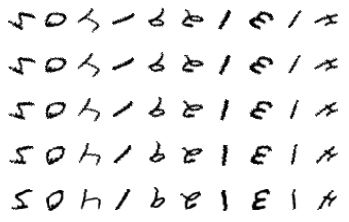

In [0]:
#Print/display some of the examples in the rotated dataset
def showGraph():
  index = 0
  print('Rotation of some images in the later stage from change of degree from (90-180)')
  for j in range(15,20):
    x = model_train[j][1].reshape(60000,28,28).data.numpy()
    y = model_train[j][2].data.numpy()
    for i in range(10):
      plt.subplot(5,10, index+1)
      plt.axis('off')
      plt.imshow(x[i],cmap='gray_r')
      index+=1

showGraph()

We can see that amount of rotation that each image experiences is different at each layer.

In [0]:
#Get data from original dataset without rotation 
def mergeData(tr_x,tr_y,te_x,te_y):
  (x_train_ro, y_train_ro), (x_test_ro, y_test_ro) = mnist.load_data()
  #Resize the shape 
  tr_x = tr_x.reshape(len(tr_x),28,28)

  #Sampling 40000 samples out of 60000 
  indexs = random.sample(range(60000),k=40000)
  x_sub = x_train_ro[indexs]
  y_sub = y_train_ro[indexs]

  #Append with mixed dataset
  tr_x = np.append(tr_x,x_sub,axis=0)
  tr_y =  np.append(tr_y,y_sub,axis=0)

  #Prepare test data
  te_x = te_x.reshape(len(te_x),28,28)
  te_x = np.append(te_x,x_test_ro,axis=0)
  te_y = np.append(te_y,y_test_ro,axis=0)

  #print the size
  print(te_x.shape,te_y.shape)
  print(tr_x.shape,tr_y.shape)

  return tr_x,tr_y,te_x,te_y


In [0]:
#Transforming x and y to the required format for processing i.e x to 3D array and labels (y) to categorical format
def transformation(x_train,y_train,x_test,y_test):

  #Reshaping the image to 3 dimensional
  num_classes = 10
  x_train = x_train.reshape(len(x_train),28,28,1)
  x_test = x_test.reshape(len(x_test),28,28,1)

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return x_train,y_train,x_test,y_test

In [0]:
def countDistribution(x_train,y_train):

  counts = list(y_train)
  unique_digits = list(set(counts))
  count_digit = []
  for i in unique_digits:
    count_digit.append(counts.count(i))

  plt.bar(unique_digits,count_digit,width=0.8,align='center')
  plt.show()

We have tackled four scenarious and build 4 models to show various trends on how the accuracy behaves with the underlying data


1.   Original MNIST dataset for train and test.
*   No manipulation of the data has been done on the images and training is testing is done on this model conventionally
* We see after 10 epochs the model has already achieved ~97% accuracy

2. Combine Rotated images from each layer and Original data from MNIST for train and test

*   We captured 45000 images of rotated digits and 40000 original data and build a model to train on it

3. Combine last layer rotated images and Original data from MNIST for train and test

*   We captured 9500 images of rotated digits and 10000 original MNIST image data and build a model to train on it

4. Train on the rotated images and test on the original MNIST data

*   We captured 60000 images of rotated digits for training the model and tested the accuracy on 10000 original images from MNIST dataset











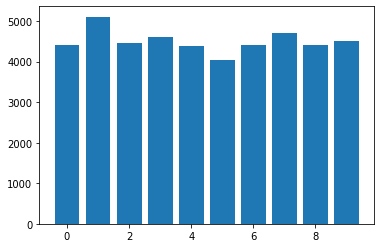

(19750, 28, 28) (19750,)
(85000, 28, 28) (85000,)
(19500, 28, 28) (19500,)
(75000, 28, 28) (75000,)


In [0]:
#function to make a combination of data from various inputs (normal MNIST, different layers of rotated MNIST)
def makeData(K,size,model,j):
  '''
  MakeData takes in four parameters:
  K is the samples of images to be taken out uniformly from each mentioned layer
  size - determines the train_size or test_size the function needs to take out the sample images
  model - is it either train or test
  j - denotes from which layer we should start the extraction upto last layer which is 19 i.e 20th Layer
  '''
  x_num = range(size)
  rotated_x = np.empty((0,784), float)
  label_y = np.empty((0,),int)

  def getUpdatedNum(x,idx):
    '''
    This function deletes the selected entries and passes on to the next layer for further computation as once the samples are 
    selected in next layer we do not wish to pick up the same sample again, thus maintaining diversity.
    '''
    new_x = []
    for i in x:
      if not (i in idx):
        new_x.append(i)

    return new_x

  while(j < 20): #as the max num of layers that are involved in rotation are 20 
    
    x = model[j][1].data.numpy()
    y = model[j][2].data.numpy()

    idx = random.sample(x_num,k=K)
    #Get the values from x and y
    x1 = x[idx]
    y1 = y[idx]

    #Append to the numpy array
    rotated_x = np.append(rotated_x,x1,axis=0)
    label_y = np.append(label_y,y1,axis=0)

    #Delete the numbers from x_num which is in range(60000)
    x_num = getUpdatedNum(x_num,idx)
    n = len(x_num)

    #Increment for next layer
    j +=1

  return rotated_x,label_y

#Case 1: Training on mnist data and testing on mnist test data (without rotation)
(tr1_x,tr1_y),(te1_x,te1_y) =  mnist.load_data()
tr1_x,tr1_y,te1_x,te1_y = transformation(tr1_x,tr1_y,te1_x,te1_y)

#Case 2: Creating combination of gradually rotated images and normal mnist
tr2_x,tr2_y = makeData(3000,60000,model_train,5)
te2_x,te2_y = makeData(650,10000,model_test,5)
countDistribution(tr2_x,tr2_y)
tr2_x,tr2_y,te2_x,te2_y = mergeData(tr2_x,tr2_y,te2_x,te2_y)
tr2_x,tr2_y,te2_x,te2_y = transformation(tr2_x,tr2_y,te2_x,te2_y)


#Case 3: Creating a combination of normal mnist and fully rotates images
tr3_x,tr3_y = makeData(35000,60000,model_train,19)
te3_x,te3_y = makeData(9500,10000,model_test,19)
tr3_x,tr3_y,te3_x,te3_y = mergeData(tr3_x,tr3_y,te3_x,te3_y)
tr3_x,tr3_y,te3_x,te3_y = transformation(tr3_x,tr3_y,te3_x,te3_y)

#Case 4: Considering only fully rotated images for training and testing on normal mnist
tr4_x,tr4_y = makeData(60000,60000,model_train,19)
(_,_), (te4_x, te4_y) = mnist.load_data()
tr4_x,tr4_y,te4_x,te4_y = transformation(tr4_x,tr4_y,te4_x,te4_y)

The distribution for sampling the images has to be uniform otherwies if the data is skewed, we might end up having only particular label images which go for training and thus resulting in significant testing accuracy loss.<br>

To achieve random yet uniform distribution we used random.sample function which takes in population size and no_of_samples needed<br>



#Model architecture:

**First layer** : Input layer (image_size = (28,28))

**Hidden layer** : Convolution layer with 32 filters and kernel_size = (3,3) and stride = 1 with valid padding
Hidden layer: Convolution layer with 64 filters and kernel_size = (3,3) and stride = 1 with valid padding.

**Activation layer**: Relu has been used - this will help in triggering the important pixels for each filter applied like edge detection, etc
Pooling Layer: It reduce the dimension of the output layer, used Max Pooling layer and size (2,2)

**Dropout**: It is quite useful to pass on relevant information to the next neuron layer when certain connection is cut off, it reduces the dependency between the neurons and learn the model efficiently

**Flatten**: The output is flattened and is ready for Fully connected NN.

**Dense Layer** : Layers of 128 neurons fully connected view with activation Relu as it overcomes the vanishing gradient problem when used with sigmoid function as activation
Lastly after training, it predicts the class of the test image as we have 10 images i.e num_classes and softmax gives the probability the image belongs to each class. One who get max(proba) is classified to that class

**Loss function**: Categorical cross-entropy as studied in the class. Shows the dependency of the loss on entropy of other classes.

**Batch size** = The number of images to be sent in each batch.

**epochs** = Number of iterations to be performed in order to converge to zero loss, due to hardware contraints we have kept the number of epochs to a relatively less number but it still achieves good accuracy


In [0]:


from sklearn import metrics
import seaborn as sns
accuracy_dict = {i:0 for i in range(1,5)}

conf_matrix = []
def NNModel(x_train,y_train,x_test,y_test,model_num):

  print(f'Training started on model {model_num}')
  num_classes = 10
  batch_size = 128
  epochs = 15

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                  input_shape=(28,28,1)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

  model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))
  score = model.evaluate(x_test, y_test, verbose=0)

  y_pred = model.predict_classes(x_test, batch_size=128)
  y_test =np.argmax(y_test, axis=1)
  conf_matrix.append(metrics.confusion_matrix(y_test,y_pred))
  accuracy_dict[model_num] = score[1]
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

NNModel(tr1_x,tr1_y,te1_x,te1_y,1)
NNModel(tr2_x,tr2_y,te2_x,te2_y,2)
NNModel(tr3_x,tr3_y,te3_x,te3_y,3)
NNModel(tr4_x,tr4_y,te4_x,te4_y,4)


Training started on model 1
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 21s 344us/step - loss: 1.0968 - acc: 0.8758 - val_loss: 0.0674 - val_acc: 0.9785
Epoch 2/15
60000/60000 [==============================] - 20s 341us/step - loss: 0.1188 - acc: 0.9663 - val_loss: 0.0555 - val_acc: 0.9827
Epoch 3/15
60000/60000 [==============================] - 20s 340us/step - loss: 0.0806 - acc: 0.9765 - val_loss: 0.0449 - val_acc: 0.9852
Epoch 4/15
60000/60000 [==============================] - 20s 335us/step - loss: 0.0659 - acc: 0.9816 - val_loss: 0.0381 - val_acc: 0.9882
Epoch 5/15
60000/60000 [==============================] - 20s 335us/step - loss: 0.0564 - acc: 0.9838 - val_loss: 0.0387 - val_acc: 0.9874
Epoch 6/15
60000/60000 [==============================] - 21s 351us/step - loss: 0.0491 - acc: 0.9853 - val_loss: 0.0418 - val_acc: 0.9883
Epoch 7/15
60000/60000 [==============================] - 20s 335us/step - loss: 0.0440 

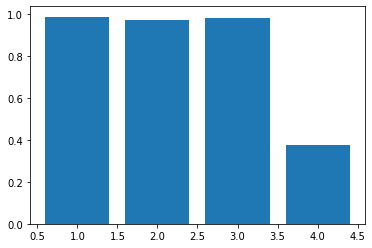

Model_1 98.94 %
Model_2 97.57000000000001 %
Model_3 98.492 %
Model_4 37.45 %


In [0]:
def graphAccuracy():
  '''
  Plot the accuracy for the different models.
  '''
  plt.bar(list(accuracy_dict.keys()),list(accuracy_dict.values()),width=0.8,align='center')
  plt.show()
  temp = accuracy_dict.copy()
  for k,v in accuracy_dict.items():
    print(f'Model_{k}',round(v,5)*100,'%')
graphAccuracy()

As the accuracy alone is not indicative of how the models are performing except for telling that model 4 has a bad performance. We will use confusion matrix to help dig further into the results. 



---


In model 2 and 3 we expect the accuracy to be very similar to the original MNIST dataset, with a few variations.
Model 2 is seen to have a lower accuracy than model 3 because model 3 is trained only on combination of fully rotated and normal MNIST data and expected to predict from the same, whereas model 2 is trained on randomly selected digits from each level of rotation and even though the ratio of digits selected overall is maintained we do not take into consideration that more 4 are loaded from layer 1 to 10 for training and more are loaded from layer 10 to 20 for testing, thus as the digits are relatively unknown to the model the accuracy drops a little. (In simple the probability of seeing a digit in test images which is similar to the one it was trained on is reduced for Model 2 when compared to model 3)

---

We expect that the bad accuracy in model 4 would be due to confusion of the model between a completely rotated 6 and 9 and vice versa. Similarly we expect the model to be confused between a rotated 4 and 7. Also a bad performance is expected between 3 and 8. We expect 1 to have a good high accuracy as it is very similar to a 180 degree rotated 1.



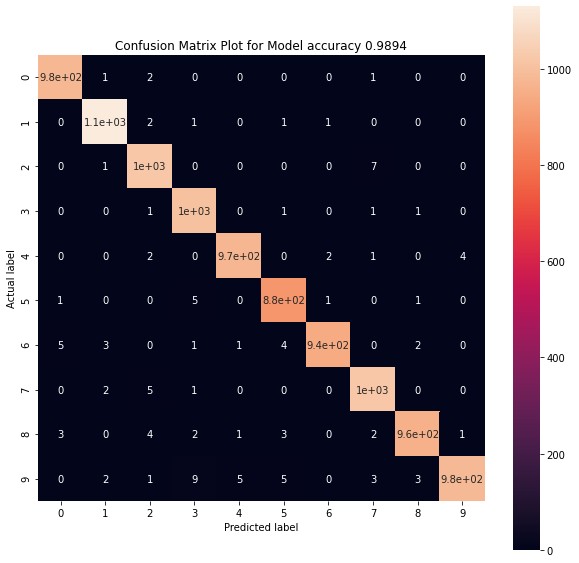

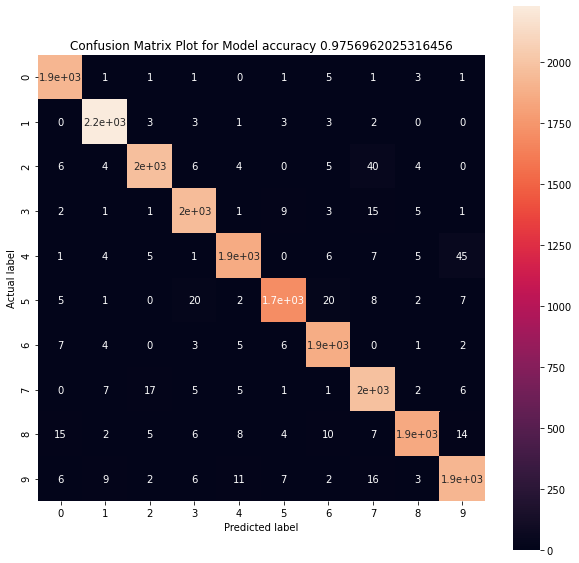

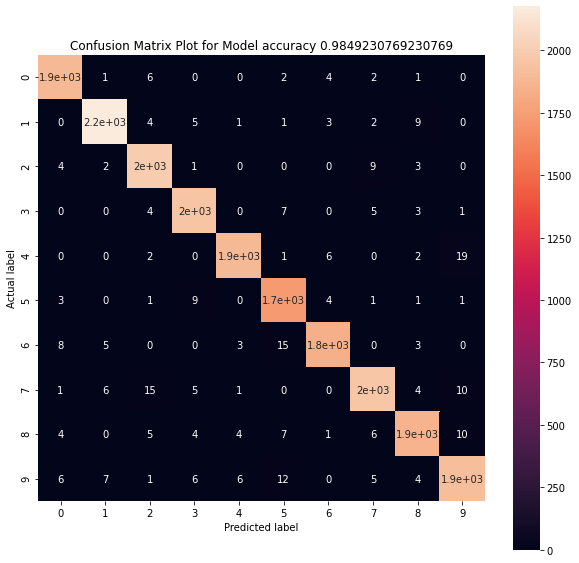

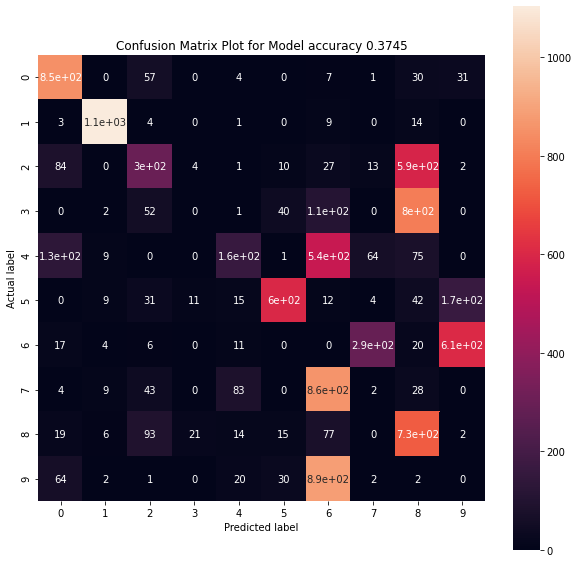

In [0]:
def confusionMatrix():
  '''
  Create a confusion matrix for all the digits from 0 to 9 for each model.
  '''
  for i in range(len(conf_matrix)):
    plt.figure(figsize=(10,10))
    sns.heatmap(conf_matrix[i], annot=True, square = True)
    plt.title(f'Confusion Matrix Plot for Model accuracy {accuracy_dict[i+1]}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

confusionMatrix()

Model 1 has a pretty good accuracy with only slight error in predicting 2 which it gives out as 7 and 5 and 3. But the overall accuracy of normal MNIST is pretty good.

---
As previously discussed Model 2 has been trained on images with all sorts of rotations and thus it is more easy to mislabel 5 and 3 or 2 and 7, which is also supported by the output of the confusion matrix.

---
Model 3 which has only 2 pattern of input images and has to predict on similar unseen images gives a good output accuracy which is comparable to model 1.

---

Model 4, the model which we could straight away decide upon the cases it might fail for did pretty bad in predicting 6 and 9 as it was trained on rotated 6 images(pattern of 9) and was taught it was 6, was asked to predict actual unrotated 6 and 9, and as seen from the confusion matrix it did perform pretty bad.(Making up almost for 20% of bad performance)
Similary there was a pretty bad performance in predicting an actual 2 which the model predicted as 7 because of it being trained on a rotated 7 which looks like 2. (10% of accuracy drop)
As was the case with 3 and 8 even in the normal MNIST model, the model 4 had a pretty bad accuracy for predicting a normal 3 as it learned a 3 in rotated form similar to 8. (10% bad performance)
Something similar was the case for a 
Values decide thought We have got 36% accuracy for training on rotated accuracy and testing on non-rotated images.

We expected the accuracy to be lower than the 36% but as we notice after 180 degree rotation, numbers like 1,0,8 remain more or less similar to reality and thus this helps in contributing to a good accuracy. Another intuition is 5 and 3 also matches to some level and could be adding to the accuracy as well.

The source for digit rotations is: [Digit_rotation](https://github.com/facebookresearch/GradientEpisodicMemoryhttps://)

### <center> Thank you!